In [1]:
from SYK_fft import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from ConformalAnalytical import *
import time


\begin{align}
    \Sigma(\tau) &= g^2 G(\tau)D(\tau) \\
    \Pi(\tau) &= -2g^2 G(\tau)G(-\tau) \\
    G(\omega_n) &= \frac{1}{i\omega_n + \mu - \Sigma(\omega_n)}\\
    D(\nu_n) &= \frac{1}{\nu_n^2 + r - \Pi(\nu_n)}
\end{align}    



In [2]:
Nbig = int(2**18)
err = 1e-3

beta = 500
mu = 0.0
g = 0.5
#r = 0.0 + 1e-8 * 1j
r = 1.
#r = g**2 * beta/2 + 0.001
#r = 1e-8
kappa = 1.

omega = (2 * np.arange(Nbig) - Nbig + 1) * np.pi/beta
nu = (2 * np.arange(Nbig) - Nbig ) * np.pi/beta
tau = (np.arange(Nbig) + 1./2) * beta/Nbig

In [3]:
Gfreetau = Freq2TimeF(1./(1j*omega + mu),Nbig,beta)
Dfreetau = Freq2TimeB(1./(nu**2 + r),Nbig,beta)
delta = 0.420374134464041
omegar2 = ret_omegar2(g,beta)
Gtau_powerlaw = -1.0*np.sign(tau)*(np.pi/np.abs(beta*np.sin(np.pi*tau/beta))) ** (2*delta)
Dtau_powerlaw =  1.0*(np.pi/np.abs(beta*np.sin(np.pi*tau/beta))) ** (2 - 4*delta)

# Gtau = Gfreetau
# Dtau = Dfreetau

#Gtau = Freq2TimeF(GconfImag(omega,g,beta),Nbig,beta)
#Dtau = Freq2TimeB(DconfImag(nu,g,beta),Nbig,beta)

#Gtau = Gtau_powerlaw * (-0.5/Gtau_powerlaw[0])
#Dtau = Dtau_powerlaw * (DfreeImagtau(tau,r,beta)[0]/Dtau_powerlaw[0])

Gtau = -0.5*np.ones(Nbig)
Dtau = 1.0*np.ones(Nbig)

itern = 0
diff = 1.
diffG = 1.
diffD = 1.
x = 0.5
xG = 0.5
xD = 0.5

while(diff>err):
    itern+=1
    diffold = 1.0*diff
    diffoldG = 1.0*diffG
    diffoldD = 1.0*diffD
    
    oldGtau = 1.0*Gtau
    oldDtau = 1.0*Dtau
    
    if itern == 1:
        oldGomega = Time2FreqF(oldGtau,Nbig,beta)
        oldDomega = Time2FreqB(oldDtau,Nbig,beta)
    else:
        oldGomega = 1.0*Gomega
        oldDomega = 1.0*Domega
    
    Sigmatau = 1.0 * kappa * (g**2) * Dtau * Gtau
    Pitau = 2.0 * g**2 * Gtau * Gtau[::-1] #KMS G(-tau) = -G(beta-tau)
    
    Sigmaomega = Time2FreqF(Sigmatau,Nbig,beta)
    Piomega =  Time2FreqB(Pitau,Nbig,beta)
    if itern < 15 : 
        Piomega[Nbig//2] = 1.0*r - omegar2
    #Piomega[Nbig//2] = 1.0*r - omegar2
    
    
    Gomega = xG*(1./(1j*omega + mu - Sigmaomega)) + (1-xG)*oldGomega
    Domega = xD*(1./(nu**2 + r - Piomega)) + (1-xD)*oldDomega
    # if itern < 10:
    #     Domega[Nbig//2] = 1/omegar2
   
    #Gtau = Freq2TimeF(Gomega - (1./(1j*omega)),Nbig,beta) - 0.5
    #Dtau = Freq2TimeB(Domega - (1./(nu**2+r)),Nbig,beta) + DfreeImagtau(tau,r,beta)
    Gtau = Freq2TimeF(Gomega,Nbig,beta)
    Dtau = Freq2TimeB(Domega,Nbig,beta)
    #Dtau = Dtau - np.imag(Dtau)
    
    diffG = np. sqrt((1.0/Nbig) * np.sum((np.abs(Gtau-oldGtau))**2)) #changed
    diffD = np. sqrt((1.0/Nbig) * np.sum((np.abs(Dtau-oldDtau))**2))
    diff = np.max([diffG,diffD])
    
    if diffG>diffoldG:
        xG/=2.
    if diffD>diffoldD:
        xD/=2.
    print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')


    
#print("itern = ",itern, " , diff = ", diff, " , x = ", xG,xD, end = '\r')


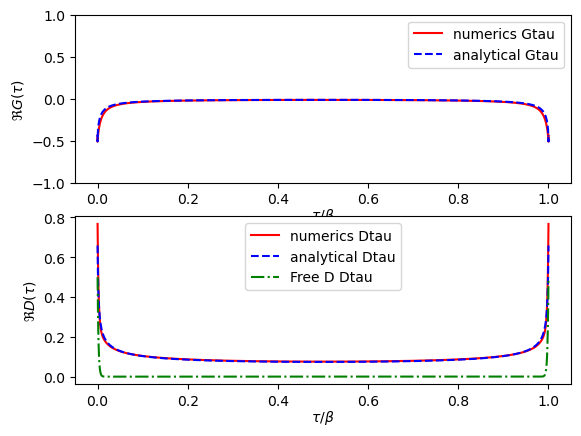

In [4]:
Gconftau = Freq2TimeF(GconfImag(omega,g,beta),Nbig,beta)
Dconftau = Freq2TimeB(DconfImag(nu,g,beta),Nbig,beta)
FreeDtau = DfreeImagtau(tau,r,beta)

fig, ax = plt.subplots(2)

ax[0].plot(tau/beta, np.real(Gtau), 'r', label = 'numerics Gtau')
ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
ax[0].set_ylim(-1,1)
ax[0].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[0].set_ylabel(r'$\Re{G(\tau)}$')
ax[0].legend()

ax[1].plot(tau/beta, np.real(Dtau), 'r', label = 'numerics Dtau')
ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[1].set_ylabel(r'$\Re{D(\tau)}$')
ax[1].legend()

plt.savefig('KoenraadEmails/WithMR_imagtime.pdf',bbox_inches='tight')


In [5]:
Gconf = GconfImag(omega,g,beta)
Dconf = DconfImag(nu,g,beta)

Text(42.597222222222214, 0.5, '$\\Im{D(\\nu_n)}$')

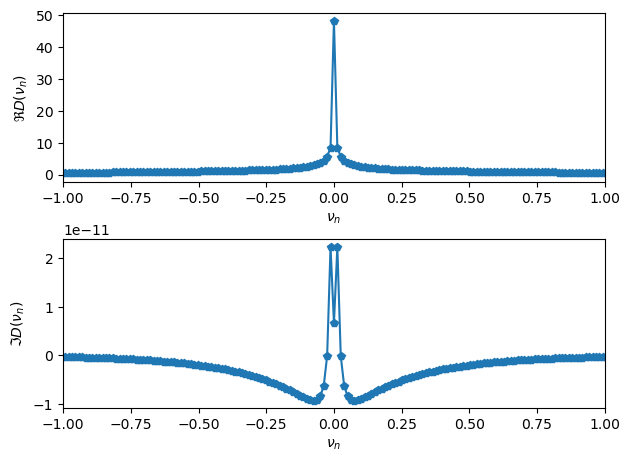

In [6]:
fig, (ax1,ax2) = plt.subplots(2)
fig.tight_layout(pad=2)

ax1.plot(nu, np.real(Domega),'p-')
ax1.set_xlim(-1,1)
ax1.set_xlabel(r'$\nu_n$')
ax1.set_ylabel(r'$\Re{D(\nu_n)}$')

ax2.plot(nu, np.imag(Domega),'p-')
ax2.set_xlim(-1,1)
ax2.set_xlabel(r'$\nu_n$')
ax2.set_ylabel(r'$\Im{D(\nu_n)}$')

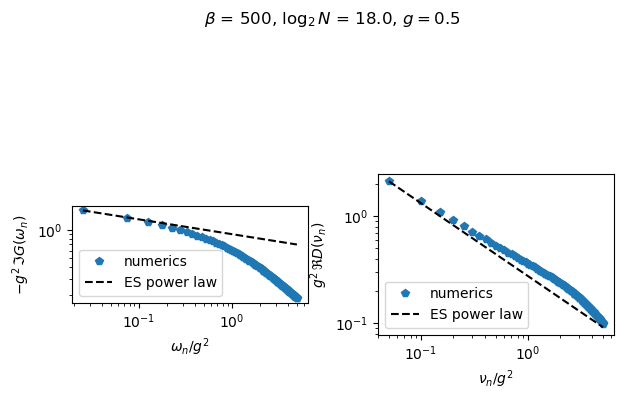

In [7]:
start, stop = Nbig//2, Nbig//2 + 100
startB, stopB = Nbig//2 + 1 , Nbig//2 + 101
delta = 0.420374134464041
alt_delta = 0.116902  

fitG_val = -np.imag(Gomega[start])*(g**2)
#fitG_val = -np.imag(Gconf[start:stop])*(g**2)
conf_fit_G = 1 * np.abs(omega/(g**2))**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val
alt_conf_fit_G = fitG_val * np.abs(omega/(g**2))**(2*alt_delta - 1)

fitD_val = np.real(Domega[startB])*(g**2)
#fitD_val = np.real(Dconf[startB:stopB])
conf_fit_D = 1 * np.abs(nu[startB:stopB]/(g**2))**(1-4*delta)
conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val
alt_conf_fit_D = 1 * np.abs(nu[startB]/(g**2))**(1-4*alt_delta)


fig,(ax1,ax2) = plt.subplots(1,2)
#fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{N}$ = ' + str(np.log2(Nbig)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(omega[start:stop]/(g**2), -np.imag(Gomega[start:stop])*(g**2),'p',label = 'numerics')
ax1.loglog(omega[start:stop]/(g**2), conf_fit_G[start:stop],'k--',label = 'ES power law')
#ax1.loglog(omega[start:]/(g**2), -np.imag(Gconf[start:])*(g**2),'m.',label = 'ES solution')
#ax1.loglog(omega[start:]/(g**2), alt_conf_fit_G[start:],'g--', label = 'alt power law')
#ax1.set_xlim(omega[start]/2,omega[start+15])
#ax1.set_ylim(1e-1,1e1)
ax1.set_xlabel(r'$\omega_n/g^2$')
ax1.set_ylabel(r'$-g^2\,\Im{G(\omega_n)}$')
ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend()


ax2.loglog(nu[startB:stopB]/(g**2), np.real(Domega[startB:stopB])*(g**2),'p',label='numerics')
ax2.loglog(nu[startB:stopB]/(g**2), conf_fit_D,'k--',label = 'ES power law')
#ax2.loglog(nu[startB:]/(g**2), np.real(Dconf[startB:]),'m.',label = 'ES solution')
#ax2.loglog(nu[startB:]/(g**2), alt_conf_fit_D,'g--', label = 'alt power law')
#ax2.set_xlim(nu[startB]/2,nu[startB+15])
#ax2.set_ylim(5e-1,100)
ax2.set_xlabel(r'$\nu_n/g^2$')
ax2.set_ylabel(r'$g^2\,\Re{D(\nu_n)}$',labelpad = None)
ax2.set_aspect('equal', adjustable='box')
ax2.legend()

#plt.savefig('lowenergy_powerlaw_ImagTime_SingleYSYK.pdf', bbox_inches = 'tight')
plt.savefig('KoenraadEmails/ImagFreqpowerlaw_withMR.pdf', bbox_inches = 'tight')


In [8]:
Piomega[Nbig//2] * Domega[Nbig//2], Gomega[Nbig//2] * Sigmaomega[Nbig//2]

((47.21649643785958+6.475574475372554e-12j),
 (-0.9445144847929222+1.0754237360183673e-12j))

In [9]:
np.allclose(np.imag(Domega),np.zeros_like(Domega))

True

In [10]:
omega[Nbig//2], nu[Nbig//2]

(0.006283185307179587, 0.0)

In [11]:
# Piconftau = 2.0 * g**2 * Gconftau * Gconftau[::-1] #KMS G(-tau) = -G(beta-tau)
# Piconfomega = Time2FreqB(Piconftau,Nbig,beta)
# Dconfomega = Time2FreqB(Dconftau,Nbig,beta)
# prodD = Dconfomega * Piconfomega 
# print(np.real(prodD[Nbig//2 - 5: Nbig//2+5]))

# Sigmaconftau = g**2 * Dconftau * Gconftau 
# Sigmaconfomega = Time2FreqF(Sigmaconftau,Nbig,beta)
# Gconfomega = Time2FreqF(Gconftau,Nbig,beta)
# prodG = Gconfomega * Sigmaconfomega 
# print(np.real(prodG[Nbig//2 - 5: Nbig//2+5]))

# fig, (ax1,ax2) = plt.subplots(2)
# fig.tight_layout(pad=3)
# fig.suptitle('Checking if E-S solution satisfies the schwinger-dyson equations')

# ax1.plot(omega,np.imag(1./(1j*omega + mu  - Sigmaconfomega)),'r',label=r'Im $\frac{1}{i\omega_n + \mu - \Sigma(\omega_n)}$') 
# ax1.plot(omega,np.imag(Gconfomega),label=r'$Im G(\omega_n)$')
# ax1.plot(omega,np.imag(Gconfomega - 1./(1j*omega + mu  - Sigmaconfomega)),'k.-',label='diffs')
# ax1.set_title('Fermions')
# ax1.legend()
# ax1.set_xlabel(r'$\omega_n$')
# ax1.set_xlim(-2,2)
# #ax1.set_ylim(-0.3,0.3)

# ax2.plot(nu,np.real(1./(nu**2 + r - Piconfomega)),'r',label = r'$\frac{1}{\nu_n^2 + r - \Pi(\nu_n)}$')
# ax2.plot(nu,np.real(Dconfomega),label=r'$D(\nu_n)$')
# ax2.plot(nu,np.real(Dconfomega - 1./(nu**2 + r - Piconfomega)),'k.-',label='diffs')
# ax2.set_title('Bosons')
# ax2.legend()
# ax2.set_xlabel(r'$\nu_n$')
# ax2.set_xlim(-2,2)
# ax2.set_ylim(-1,1)

# #plt.savefig('Checking consistency of E-S solution.pdf')

In [12]:
1/(omega[2]-omega[1]) # number of points in the window 0 - 1 for omega

79.57747154554767

(-0.5, 0.5)

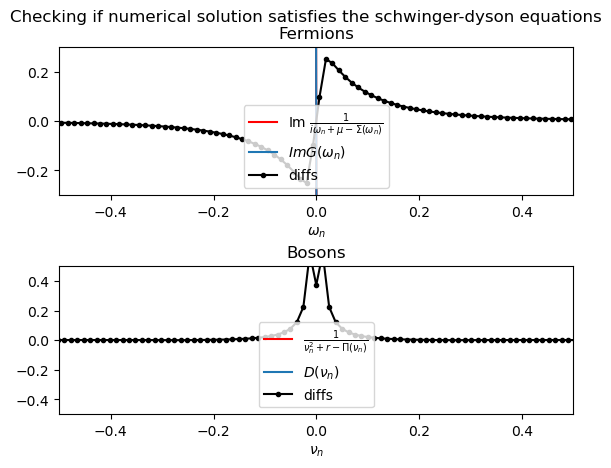

In [13]:
fig, (ax1,ax2) = plt.subplots(2)
fig.tight_layout(pad=3)
fig.suptitle('Checking if numerical solution satisfies the schwinger-dyson equations')

ax1.plot(omega,np.imag(1./(1j*omega + mu  - Sigmaomega)),'r',label=r'Im $\frac{1}{i\omega_n + \mu - \Sigma(\omega_n)}$') 
ax1.plot(omega,np.imag(Gomega),label=r'$Im G(\omega_n)$')
ax1.plot(omega,np.imag(Gomega - 1./(1j*omega + mu  - Sigmaomega)),'k.-',label='diffs')
ax1.set_title('Fermions')
ax1.legend()
ax1.set_xlabel(r'$\omega_n$')
ax1.set_xlim(-0.5,0.5)
ax1.set_ylim(-0.3,0.3)

ax2.plot(nu,np.real(1./(nu**2 + r - Piomega)),'r',label = r'$\frac{1}{\nu_n^2 + r - \Pi(\nu_n)}$')
ax2.plot(nu,np.real(Domega),label=r'$D(\nu_n)$')
ax2.plot(nu,np.abs(Domega - 1./(nu**2 + r - Piomega)),'k.-',label='diffs')
ax2.set_title('Bosons')
ax2.legend()
ax2.set_xlabel(r'$\nu_n$')
ax2.set_xlim(-0.5,0.5)
ax2.set_ylim(-0.5,0.5)

#plt.savefig('Checking consistency of Numerical solution.pdf')

In [14]:
np.diff(nu[startB:startB+10])

array([0.01256637, 0.01256637, 0.01256637, 0.01256637, 0.01256637,
       0.01256637, 0.01256637, 0.01256637, 0.01256637])